## Import Dataset and Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_excel("grants_dataset.xlsx", header=1)

In [3]:
df.head(3)

,Rank,Grant ID,Grant Number,Title,Title translated,Abstract,Abstract translated,Funding Amount,Currency,Funding Amount in USD,...,ICRP Cancer Types 2,ICRP Cancer Types 3,ICRP Cancer Types 4,ICRP Cancer Types 5,ICRP CSO Categories,ICRP CSO 1,ICRP CSO 2,ICRP CSO 3,ICRP CSO 4,ICRP CSO 5
0,100,grant.8540743,1945924.0,EAGER: Navigating Unmanned Underwater Vehicles...,EAGER: Navigating Unmanned Underwater Vehicles...,"In the Arctic, air-sea interactions and biolog...","In the Arctic, air-sea interactions and biolog...",293134,USD,293134,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100,grant.8567528,1926648.0,QCIS-FF: A Software Stack for Quantum Computing,QCIS-FF: A Software Stack for Quantum Computing,Quantum computers have emerged quickly and qua...,Quantum computers have emerged quickly and qua...,250000,USD,250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100,grant.8539665,1926585.0,QCIS-FF: Quantum Computer Systems Faculty Fell...,QCIS-FF: Quantum Computer Systems Faculty Fell...,Quantum computing is at the cusp of a revoluti...,Quantum computing is at the cusp of a revoluti...,250000,USD,250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.isna().sum()

Rank                    0
Grant ID                0
Grant Number          116
Title                   0
Title translated        0
                    ...  
ICRP CSO 1          49890
ICRP CSO 2          50000
ICRP CSO 3          49976
ICRP CSO 4          49998
ICRP CSO 5          50000
Length: 63, dtype: int64

## Data Cleaning

In [5]:
#Drop columns not used in analysis
df = df.iloc[:,:33]

#Drop Currency and Funding Amount Columns 
df = df.drop(["Currency", "Funding Amount", "Grant Number", "Research Organization - standardized", "Rank"], axis = 1)

In [6]:
#Inspect Funding Amount in USA column 
print((df["Funding Amount in USD"].isnull() == True).sum())

#check datatype for this column 
print(df["Funding Amount in USD"].dtype)

#Rename column
df.rename(columns = {"Funding Amount in USD": "funding_amount"}, inplace = True)
#There are no missing values in this column 

0
int64


In [7]:
#Rename columns to allow for easy data manipulation 
df.rename(columns = {"Research Organization - original": "research_org", "Start Date": "start_date", "Start Year": "start_year", "End Date": "end_date", "End Year": "end_year", "Grant ID": "grant_id"},
          inplace = True)

In [8]:
#Drop columns that wouldnt be used in models 
df = df.drop(["Resulting publications", "Source Linkout", "Dimensions URL", "FOR (ANZSRC) Categories", "Title", "Abstract"], axis=1)

#clean grant_id column to get rid of the prefix "grant_id"
# remove the unwanted parts of the id in "grant_id" column
df['grant_id'] = df['grant_id'].map(lambda x: x.lstrip("grant."))

# rename "Title" to "title"
df = df.rename(columns={"Title translated": "title"})

# rename "Abstract translated"to "abstract"
df = df.rename(columns={"Abstract translated": "abstract"})

#Rename columns to allow for easy data manipulation 
df.rename(columns = {"GRID ID": "grid_id", 'City of Research organization': "research_city", "Researchers": "researchers", "State of Research organization": "research_state", "Funder": "funder", "Funder Group": "funder_group", "Funder Country": "funder_country"}, inplace = True)

In [9]:
df.shape

(50000, 22)

## Feature Extraction

In [10]:
# get the length of both the title and abstarct cells, put in there own column
df['title_len'] = df['title'].str.split().str.len()
df['abstract_len'] = df['abstract'].str.split().str.len()

In [11]:
# change columns to datatime format for easy subtraction
df['duration'] = (pd.to_datetime(df['end_date']) - pd.to_datetime(df['start_date'])).dt.days

In [12]:
# list of the top twenty institutions in America
top_twenty_unis = ["Princeton University", "Columbia University", "Harvard University", "Massachusetts Institue of Technology",
       "Yale University", "Stanford University", "University of Chicago", "University of Pennsylvania",
       "California Institute of Technology", "Duke University", "Johns Hopkins University", "Northwestern University",
       "Dartmouth College", "Brown University", "Vanderbilt University", "Washington University in St. Louis",
       "Cornell University", "Rice University", "University of Notre Dame", "University of California Los Angeles"]
# make the list in a pattern that easy to parse
pattern = "|".join(top_twenty_unis)

# create a column with a boolean value if the research organization is in the top twenty
df['is_top_twenty'] = df['research_org'].str.contains(pattern)
df["is_top_twenty"] = df["is_top_twenty"].astype(int) # make it show as 0 or 1

In [13]:
# count the number of researchers
df['no_researchers'] = df['researchers'].str.count(';') + 1

In [14]:
# list of the top twenty institutions in America
college_or_uni = ["College", "University"]
# make the list in a pattern that easy to parse
pattern = "|".join(college_or_uni)

# create a column with a boolean value if the research organization is in the top twenty
df['is_academic'] = df['research_org'].str.contains(pattern)
df["is_academic"] = df["is_academic"].astype(int) # make it show as 0 or 1

In [15]:
#Inpect funding data
df["funding_amount"].describe()

count    5.000000e+04
mean     4.742319e+05
std      3.652333e+06
min      0.000000e+00
25%      1.000010e+05
50%      2.472350e+05
75%      4.457380e+05
max      3.804671e+08
Name: funding_amount, dtype: float64

In [16]:
def make_funding_bin(x):
    
    if x == 0:
        return "bin_1"
    
    elif (x > 0 and x < 100000):
        return "bin_2"
    
    elif (x >= 100000 and x < 300000):
        return "bin_3"

    elif (x >= 300000):
        return "bin_4"
    
df['funding_bin_1'] = df['funding_amount'].apply(make_funding_bin)

#Use qcut to make an equal frequency binning
df['funding_bin_2'] = pd.qcut(df['funding_amount'], q=6)

df['funding_bin_2'] = df['funding_bin_2'].astype(str)

In [17]:
# extract the first 2 characters from the subject
df['for_1_abbr'] = df['FOR 1'].str[:2]

In [18]:
def bin_fields (x):
    
    if x == "09":
        return "engineering"
    elif x in ["08", "02" "01"]:
        return "computational"
    elif x in ["11", "06", "03"]:
        return "health and medicine"
    elif x in ["04", "05", "07"]:
        return "natural science"
    else:
        return "other"
    
df['field_bins'] = df['for_1_abbr'].apply(bin_fields)

In [19]:
#Drop more columns that wouldnt be used in models 
df = df.drop(["FOR 2", "FOR 3", "FOR 3", "FOR 4", "FOR 5"], axis=1)

In [20]:
#Drops rows with null values
df = df.dropna()

In [21]:
#One hot-encode columns for final analysis 
df_final = pd.get_dummies(df.copy(), columns = ['funder', 'field_bins'])

## Classification 

In [22]:
#Import libraries
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [23]:
df_final = df_final.drop(["grant_id", "title", "abstract", "end_date",
                          "researchers", "research_org", "grid_id", "research_city", 
                          "research_state", "Country of Research organization", "funder_group", 
                          "start_date", "funder_country", 'FOR 1', 'for_1_abbr'], axis=1)

### Feature Selection Using Random Forests

In [25]:
y = df_final["funding_bin_1"]
X = (df_final.drop(["funding_bin_1", "funding_bin_2", "funding_amount"], axis = 1))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [27]:
feat_labels = np.array((df_final.drop(["funding_bin_1", "funding_bin_2", "funding_amount"], axis = 1)).columns)

In [28]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feat_labels, clf.feature_importances_):
    print(feature)

('start_year', 0.0969085345458201)
('end_year', 0.1111306806064073)
('title_len', 0.12135767607007959)
('abstract_len', 0.2083790405316093)
('duration', 0.2894444300533851)
('is_top_twenty', 0.012716078616444642)
('no_researchers', 0.06233571035808061)
('is_academic', 0.017490406422552826)
('funder_Directorate for Biological Sciences', 0.00378140415299588)
('funder_Directorate for Computer & Information Science & Engineering', 0.015121456171526854)
('funder_Directorate for Education & Human Resources', 0.006229640147969052)
('funder_Directorate for Engineering', 0.008268499553227561)
('funder_Directorate for Geosciences', 0.0041203586828300574)
('funder_Directorate for Mathematical & Physical Sciences', 0.010110381080692721)
('funder_Directorate for Social, Behavioral & Economic Sciences', 0.003336533538654627)
('funder_National Science Foundation', 0.00015451181514822995)
('funder_Office of Budget, Finance and Award Management', 5.949673756409615e-06)
('funder_Office of Inspector Gene

### Naive Bayes

In [78]:
# y = df_final["funding_bin_1"].values
# X = df_final.copy().drop(["funding_bin_1", "funding_bin_2", "funding_amount"], axis = 1)

y =(df_final['funding_bin_1']).values
X = (df_final[['duration', 'is_top_twenty', 'no_researchers', 'abstract_len',
               'title_len', 'start_year', 'end_year', 'is_academic', 'funder_Directorate for Computer & Information Science & Engineering'
              ,'funder_Directorate for Mathematical & Physical Sciences']]).values

#split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [79]:
gnb = GaussianNB(priors=None, var_smoothing=1e-9)
gnb.fit(X_train, y_train)

y_predict = gnb.predict(X_test)

conf_mat = confusion_matrix(y_test, y_predict, labels=['bin_1', 'bin_2', 'bin_3', 'bin_4'])
print(conf_mat)

print('Accuracy: ', accuracy_score(y_test, y_predict))

[[   0   12    2    0]
 [   0 2150  819  384]
 [   0  916 2006 2038]
 [   0  288  919 4878]]
Accuracy:  0.6268387454898695


In [80]:
scores = cross_val_score(gnb, X_train, y_train, cv = 5, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Cross-validation scores:[0.62042819 0.61626524 0.62185874 0.63137546 0.62141264]
Average cross-validation score: 0.6223


#### Naive Bayes with Oversampling

In [81]:
oversample = RandomOverSampler(sampling_strategy= 'minority')
X_over, y_over = oversample.fit_resample(X, y)

X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_over, y_over, test_size = 0.3)

gnb = GaussianNB(priors=None, var_smoothing=1e-9)
gnb.fit(X_train_o, y_train_o)

y_predict_o = gnb.predict(X_test_o)

conf_mat = confusion_matrix(y_test_o, y_predict_o, labels=['bin_1', 'bin_2', 'bin_3', 'bin_4'])
print(conf_mat)

print('Accuracy: ',accuracy_score(y_test_o, y_predict_o))

scores = cross_val_score(gnb, X_train_o, y_train_o, cv = 5, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

[[4030  977  444  769]
 [1215 1242  541  245]
 [ 886  535 1690 1818]
 [ 492  138  797 4692]]
Accuracy:  0.5681829262347033
Cross-validation scores:[0.54910155 0.55709957 0.57120468 0.554592   0.55009926]
Average cross-validation score: 0.5564


### Logistic Regression

In [82]:
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [83]:
conf_mat = confusion_matrix(y_test, y_pred, labels=['bin_1', 'bin_2', 'bin_3', 'bin_4'])
print(conf_mat)

print('Accuracy: ', accuracy_score(y_test, y_pred))

[[   0   12    1    1]
 [   0 2192  903  258]
 [   0  769 2463 1728]
 [   0  216 1288 4581]]
Accuracy:  0.6408548431862336


In [84]:
scores = cross_val_score(logreg, X_train, y_train, cv = 5, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Cross-validation scores:[0.64644663 0.64005352 0.63851301 0.64594796 0.63806691]
Average cross-validation score: 0.6418


#### Logistic Regression with Oversampling

In [85]:
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000)

logreg.fit(X_train_o, y_train_o)
y_pred_o = logreg.predict(X_test_o)


conf_mat = confusion_matrix(y_test_o, y_pred_o, labels=['bin_1', 'bin_2', 'bin_3', 'bin_4'])
print(conf_mat)

print('Accuracy: ', accuracy_score(y_test_o, y_pred_o))

scores = cross_val_score(logreg, X_train_o, y_train_o, cv = 5, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

[[4370  325  775  750]
 [2059  319  557  308]
 [1262   67 1748 1852]
 [ 496   14  963 4646]]
Accuracy:  0.5403442055482424
Cross-validation scores:[0.54356456 0.5363076  0.55114408 0.53975551 0.54821858]
Average cross-validation score: 0.5438


#### K Nearest Neighbours 

In [107]:
#temporarily drop categorical columns 
# y = df_final["funding_bin_1"].values
# X = df_final.copy().drop(["funding_bin_1", "funding_bin_2", "funding_amount"], axis = 1).values

y =(df_final['funding_bin_1']).values
X = (df_final[['duration', 'is_top_twenty', 'no_researchers', 'abstract_len',
               'title_len', 'start_year', 'end_year', 'is_academic', 'funder_Directorate for Computer & Information Science & Engineering'
              ,'funder_Directorate for Mathematical & Physical Sciences']]).values

In [108]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.3)

In [109]:
knn = KNeighborsClassifier(n_neighbors=11)
 
knn.fit(X_train, y_train)
 
# Predict on dataset which model has not seen before
y_pred = knn.predict(X_test)

In [110]:
conf_mat = confusion_matrix(y_test, y_pred, labels=['bin_1', 'bin_2', 'bin_3', 'bin_4'])
print(conf_mat)

print(knn.score(X_test, y_test))

[[   0    8    2    2]
 [   0 2242  831  266]
 [   0  851 2293 1821]
 [   0  262 1504 4330]]
0.61511240632806


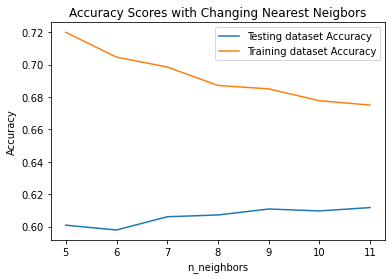

In [42]:
#find the best k value 

neighbors = np.arange(5,12)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
 
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
     
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)
 

 # Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
 
plt.legend()
plt.title('Accuracy Scores with Changing Nearest Neigbors')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

In [111]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn, X_train, y_train, cv = 5, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Cross-validation scores:[0.60303301 0.60258698 0.60104089 0.60847584 0.59925651]
Average cross-validation score: 0.6029


#### KNN with Oversampling

In [112]:
scores = cross_val_score(knn, X_train_o, y_train_o, cv = 5, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Cross-validation scores:[0.72283744 0.7180023  0.7197785  0.71695748 0.72416675]
Average cross-validation score: 0.7203


### Using Neural Networks for Regression 

In [45]:
#Report Libraries
#Import libraries 
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [46]:
import tensorflow as tf
tf.config.set_visible_devices(tf.config.get_visible_devices()[0:1])

2021-12-10 00:25:28.983378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-10 00:25:28.983785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-10 00:25:28.987440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-10 00:25:28.987821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-10 00:25:28.988587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [115]:
y =(df_final['funding_amount']).values
y = y.reshape(-1,1)
X = (df_final[["start_year", "duration", "end_year", "abstract_len", "title_len", "no_researchers", 'funder_Directorate for Geosciences', "is_academic",
              'is_top_twenty', 'funder_Directorate for Engineering']]).values

In [116]:
target_scaler = MinMaxScaler()
target_scaler.fit(y)

# transform target variables
y = target_scaler.transform(y)

In [117]:
#split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [118]:
#Transform data 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [119]:
# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(50, activation = 'relu', input_dim = X_train.shape[1]))

# Adding the second hidden layer
model.add(Dense(units = 25, activation = 'relu'))

# # Adding the third hidden layer
# model.add(Dense(units = 27, activation = 'relu'))

# Adding the output layer
model.add(Dense(units = 1,activation = 'linear'))

In [120]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 1,851
Trainable params: 1,851
Non-trainable params: 0
_________________________________________________________________


In [121]:
model.compile(optimizer = 'adam',loss = 'mse')

In [122]:
history = model.fit(X_train, y_train, epochs= 10, batch_size= 50,  verbose=1, validation_split=0.2)

Epoch 1/10
515/515 [==============================] - 1s 741us/step - loss: 0.0088 - val_loss: 0.0014
Epoch 2/10
515/515 [==============================] - 0s 658us/step - loss: 9.8419e-04 - val_loss: 7.7550e-04
Epoch 3/10
515/515 [==============================] - 0s 636us/step - loss: 5.8049e-04 - val_loss: 4.7665e-04
Epoch 4/10
515/515 [==============================] - 0s 640us/step - loss: 4.0106e-04 - val_loss: 3.2395e-04
Epoch 5/10
515/515 [==============================] - 0s 625us/step - loss: 3.0324e-04 - val_loss: 2.4494e-04
Epoch 6/10
515/515 [==============================] - 0s 635us/step - loss: 2.4714e-04 - val_loss: 1.8970e-04
Epoch 7/10
515/515 [==============================] - 0s 642us/step - loss: 2.0555e-04 - val_loss: 1.8810e-04
Epoch 8/10
515/515 [==============================] - 0s 621us/step - loss: 1.7537e-04 - val_loss: 1.2525e-04
Epoch 9/10
515/515 [==============================] - 0s 615us/step - loss: 1.5442e-04 - val_loss: 1.2441e-04
Epoch 10/10
515/51

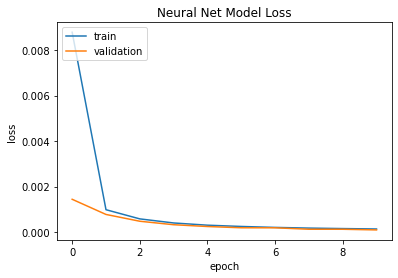

In [123]:
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Neural Net Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [124]:
y_pred = model.predict(X_test)

In [125]:
# invert transform on predictions
y_pred = target_scaler.inverse_transform(y_pred)
y_test = target_scaler.inverse_transform(y_test)

In [126]:
mean_squared_error(y_test, y_pred)

24399974319406.0

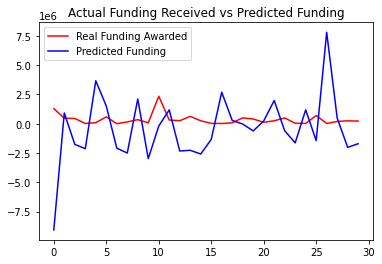

In [127]:
plt.plot(y_test[0:30], color = 'red', label = 'Real Funding Awarded')
plt.plot(y_pred[0:30], color = 'blue', label = 'Predicted Funding')
plt.title('Actual Funding Received vs Predicted Funding')
plt.legend()
plt.show()

### Feature Selection (Regression) with Decision Trees

In [128]:
features = (df_final.copy().drop(["funding_bin_1", "funding_bin_2", "funding_amount"], axis = 1)).columns

In [129]:
y =(df_final['funding_amount']).values
X = (df_final.copy().drop(["funding_bin_1", "funding_bin_2", "funding_amount"], axis = 1)).values

In [65]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33)

In [66]:
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train,y_train)

RandomForestRegressor(random_state=0)

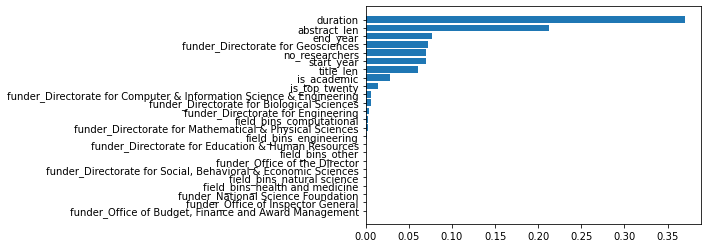

In [67]:
f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

In [68]:
rfe = RFECV(rf,cv=2,scoring="neg_mean_squared_error")

rfe.fit(X_train,y_train)

RFECV(cv=2, estimator=RandomForestRegressor(random_state=0),
      scoring='neg_mean_squared_error')

In [69]:
selected_features = np.array(features)[rfe.get_support()]

#### Multiple Linear Regression 

In [130]:
linreg = linear_model.LinearRegression()

In [131]:
y =(df_final['funding_amount']).values
y = y.reshape(-1,1)

X = (df_final[["start_year", "duration", "end_year", "abstract_len", "title_len", "no_researchers", 'funder_Directorate for Geosciences', "is_academic",
              'is_top_twenty', 'funder_Directorate for Engineering']]).values

In [132]:
target_scaler = MinMaxScaler()
target_scaler.fit(y)

# transform target variables
y = target_scaler.transform(y)

In [133]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30)

In [134]:
linreg.fit(X_train, y_train)

y_predict = linreg.predict(X_test)

In [135]:
# invert transform on predictions
y_predict = target_scaler.inverse_transform(y_predict)
y_test = target_scaler.inverse_transform(y_test)

In [136]:
mean_squared_error(y_test, y_predict)

4899932387687.01

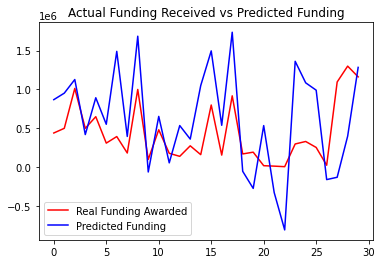

In [137]:
plt.plot(y_test[0:30], color = 'red', label = 'Real Funding Awarded')
plt.plot(y_predict[0:30], color = 'blue', label = 'Predicted Funding')
plt.title('Actual Funding Received vs Predicted Funding')
plt.legend()
plt.show()